<a href="https://colab.research.google.com/github/iqbalfikdata/CLUSTERING/blob/master/CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
%matplotlib inline
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
mal = pd.read_csv('/content/Pengunjung_mall.csv')
mal.rename(columns={'Pendapatan (juta Rp)' : 'Pendapatan',
                    'Rating_pengeluaran (1-100)':'Rating_pengeluaran'}, inplace=True)
mal.head(4)

#Data ini diambil dari https://www.megabagus.id/?s=kmeans

,IDPelanggan,Kelamin,Usia,Pendapatan,Rating_pengeluaran
0,1,Laki,19,15,39
1,2,Laki,21,15,81
2,3,Perempuan,20,16,6
3,4,Perempuan,23,16,77


In [0]:
#Kita akan melakukan pengelompokan konsumen berdasarkan Pendapatan dan Rating_pengeluaran,
#jika rentang nilai Pendapatan dan rentang nilai Rating pengeluaran berbeda jauh, maka harus
#dilakukan preprocessing, tetapi melihat tabel diatas, rentang keduanya relatif sama, jadi tidak
#perlu dilakukan preprocessing

#Berapa banyak cluster seharusnya dalam pengelompokan itu?
#kita akan menggunakan metrics evaluasi silhouette score untuk mengetahuinya

X = mal.iloc[:, 3:].values
pass

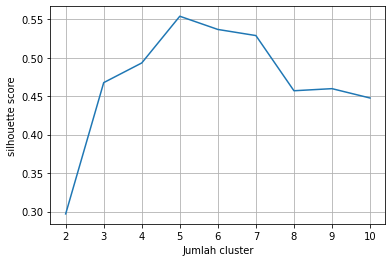

In [5]:
sil_score_list = []
for i in range(2, 11):
  kmeans = KMeans(i)
  labels = kmeans.fit_predict(X)
  sil_score = silhouette_score(X, labels)
  sil_score_list.append(sil_score)
plt.plot(range(2, 11), sil_score_list)
plt.xlabel('Jumlah cluster')
plt.ylabel('silhouette score')
plt.grid()
plt.show()

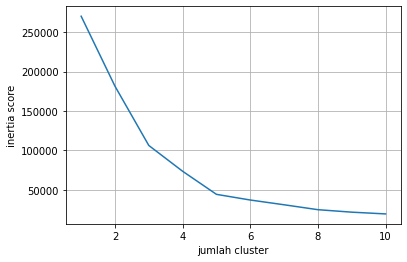

In [6]:
#Terlihat bahwa untuk jumlah cluster=5 memiliki silhouette skor yang paling tinggi
#Berarti dapat dikatakan bahwa dalam dataset ini, Pengelompokan konsumen berdasarkan Pendapatan dan
#rating pengeluaran menjadi 5 cluster adalah yang terbaik

#Selain silhouette_score, kita juga bisa menggunakan nilai inersia sebagai pedoman, jumlah cluster
#terbaik dipilih saat grafik inersia nya converge, yaitu membentuk elbow (siku)

inertia_list = []
for i in range(1, 11):
  kmeans = KMeans(i)
  labels = kmeans.fit_predict(X)
  inertia_score = kmeans.inertia_
  inertia_list.append(inertia_score)
plt.plot(range(1, 11), inertia_list)
plt.xlabel('jumlah cluster')
plt.ylabel('inertia score')
plt.grid()

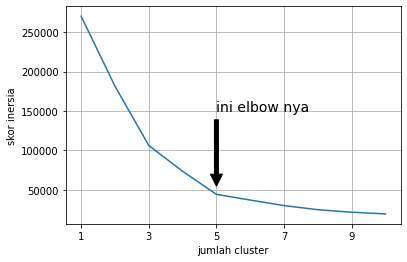

In [7]:
#Tampak bahwa grafik tersebut membentuk elbow saat jumlah cluster nya = 5
#Hasil nya sama dengan metrics evaluasi silhouette score tadi ^_^

inertia_list = []
for i in range(1, 11):
  kmeans = KMeans(i)
  labels = kmeans.fit_predict(X)
  inertia_score = kmeans.inertia_
  inertia_list.append(inertia_score)
plt.plot(range(1, 11), inertia_list)
plt.annotate('ini elbow nya', xy=(5, 50000), xytext=(5, 150000),
             arrowprops=dict(facecolor='k', shrink=.05), fontsize=14)
plt.xlabel('jumlah cluster')
plt.ylabel('skor inersia')
plt.xticks([1, 3, 5, 7, 9])
plt.grid()

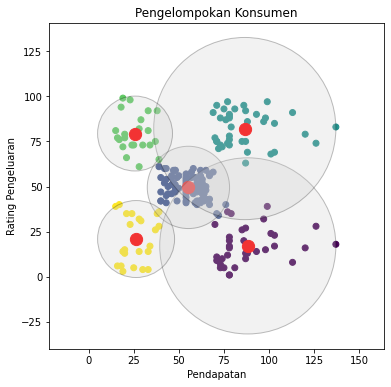

In [9]:
#Sekarang kita akan visualisasi kelima cluster tersebut

kmeans = KMeans(5)
labels = kmeans.fit_predict(X)
pusat = kmeans.cluster_centers_
jejari = [cdist(X[labels==i], [p]).max() for i, p in enumerate(pusat)]   #me-return jarak pusat cluster ke datapoint terjauh
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X[:,0], X[:,1], c=labels, cmap='viridis')
ax.scatter(pusat[:,0], pusat[:,1], c='red', s=150)
for j, p in zip(jejari, pusat):
  lingkaran = plt.Circle(p, j, color='k', alpha=.25, fc='#CCCCCC')
  ax.axis('equal')
  ax.add_patch(lingkaran)
  ax.set_xlabel('Pendapatan')
  ax.set_ylabel('Rating Pengeluaran')
  ax.set_title('Pengelompokan Konsumen')

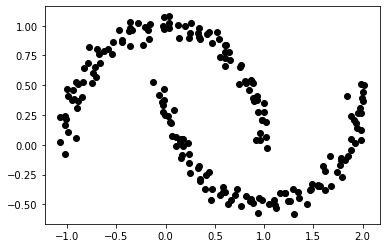

In [10]:
#Dalam beberapa tipe dataset (pola distribusi scatter plot) tertentu, KMeans memiliki kekurangan
#terutama untuk sebaran data point yang memiliki kerapatan yang berbeda - beda juga memiliki
#bentuk geometri yang rumit

#Seperti contoh dibawah:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:,0], Xmoon[:,1], c='black')

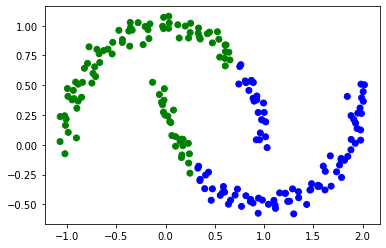

In [11]:
#kita akan meminta KMeans utk mengelompokkan dataset diatas menjadi 2 buah cluster

kmeans = KMeans(2)
labels1 = kmeans.fit_predict(Xmoon)
plt.scatter(Xmoon[:,0], Xmoon[:,1], c=labels1,cmap=ListedColormap(('blue', 'green')))

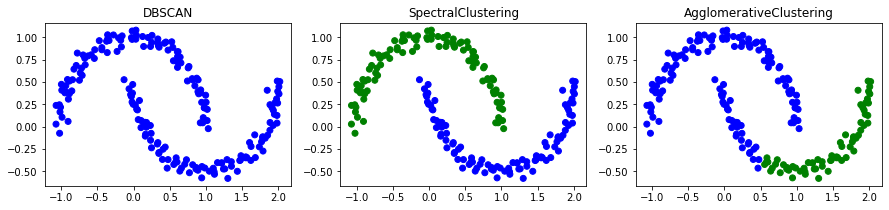

In [12]:
#Terlihat bahwa KMeans kurang baik dalam membedakan dua cluster diatas
#Kita akan meminta tolong kepada 3 algoritma lain, yaitu DBSCAN, SpectralClustering dan AgglomerativeClustering

algos = [DBSCAN(), SpectralClustering(n_clusters=2, affinity='nearest_neighbors'),
         AgglomerativeClustering(n_clusters=2)]
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for ax, algo in zip(axes[0:], algos):
  labels2 = algo.fit_predict(Xmoon)
  ax.scatter(Xmoon[:,0], Xmoon[:,1], c=labels2, cmap=ListedColormap(('blue', 'green')))
  ax.set_title('{}'.format(algo.__class__.__name__))

Text(0.5, 1.0, 'DBSCAN')

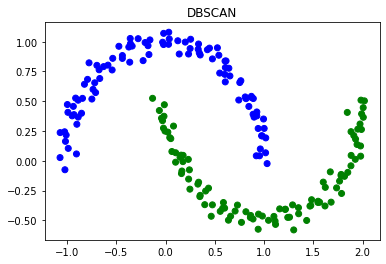

In [13]:
#Well, ternyata yang sukses meng-cluter adalah SpektralClustering, untuk DBSCAN sebenarnya kita
#belum men-tuning paramater pentingnya, yaitu eps dan min_samples
#parameters eps lebih penting, makin besar nilai eps nya makin banyak titik yang dianggap satu cluster (cluster yang sama)
#sedangkan makin kecil nilai eps, makin banyak point yang dianggap sebagai noise

#Dari hasil kita diaatas dengan DBSCAN, semua titik dianggap 1 cluster, artinya eps kita terlalu besar
#kita harus menurunkan nilai eps ini, secara default nilai eps adalah 0,5, coba kita turunkan menjadi 0,2

dbscan = DBSCAN(eps = .2)
labels_db = dbscan.fit_predict(Xmoon)
plt.scatter(Xmoon[:,0], Xmoon[:,1], c=labels_db, cmap=ListedColormap(('blue', 'green')))
plt.title('{}'.format(dbscan.__class__.__name__))

In [15]:
#Yes, berarti DBSCAN dengan eps=0,2 dan SpectralClustering berhasil membagi dataset kedalam 2 cluster

#Sejauh ini, kita yang memilih sendiri di awal berapa jumlah clusternya, bagaimana jika kita meminta
#algoritma yang menentukan sendiri berapa cluster terbaiknya? ini bisa dilakukan dengan BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=15, n_init=10)
bgm.fit_predict(X)
print(np.round(bgm.weights_, 3))

[0.123 0.376 0.2   0.177 0.124 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.   ]


In [16]:
#Algoritma GaussianMixture menjelaskan bahwa cluster tertentu berasal dari distribusi gauss dengan
#parameter mean, varians dan densitas tertentu. Jika suatu cluster memiliki bobot = 0, maka dapat
#dikatakan tidak ada cluster disana, di awal kita menetapkan jumlah clusternya adalah 15, karena
#kita mendapatkan 10 buah angka Nol, maka cluster yang kita miliki tinggal 15 - 10 = 5 cluster
#Wah, hasil ini sama dengan metode silhouette_score dan inersia pada KMeans tadi ^_^

#Sekarang, misalkan kita ingin mendeteksi apakah ada outlier pada dataset kita, outlier adalah
#data point yang nilai nya terlalu ekstrim dibandingkan dengan mayoritas data yang ada, setelah
#outlier ini hilang, maka model yang kita buat nanti akan menjadi lebih baik secara signifikan
#outlier/anomali detection ini bisa dilakukan dengan GaussianMixture dengan menetapkan batas bawah
#tertentu, datapoint yang berada di kerapatan yang rendah akan dianggap sebagai outlier
#biasanya dalam bisnis tertentu telah ditetapkan berapa batas bawahnya, dalam contoh ini kita
#misalkan ambil batas bawahnya adalah 0,3
#Jadi datapoint yang ada dibawah batas bawah ini akan dianggap sebagai outlier

batas_bawah = 0.2
gm = GaussianMixture(n_components=5, n_init=10)
gm.fit(X)
densitas = gm.score_samples(X)
densitas_batas_bawah = np.percentile(densitas, batas_bawah)
outlier = X[densitas < densitas_batas_bawah]
print('berikut adalah outlier pada dataset kita: {}'.format(outlier))

berikut adalah outlier pada dataset kita: [[137  83]]


In [0]:
#Wah ternyata yang berpendapatan 137 juta dan rating pengeluarannya 83 dianggap sebagai Outlier ^_^
#Mari kita hapus outlier nya agar model yang hendak kita buat untuk klasifikasi memiliki performa yang bagus

index_drop = mal[(mal['Pendapatan']==137) & (mal['Rating_pengeluaran']==83)].index
index_drop
mal.drop(index=index_drop, inplace=True)

In [20]:
#Ok pertanyaan lebih jauh, dalam pengelompokan menjadi 5 cluster tadi, variabel independent manakah
#yang paling berperan? kita akan gunakan LGBMClassifier untuk mengetahuinya
#kita buat dulu tabel baru tanpa outlier nya dan menambahkan kolom cluster sebagai variabel target nya

x = mal.iloc[:, 3:].values
kmeans = KMeans(5)
y = kmeans.fit_predict(x)
y = y.reshape(y.shape[0], 1)
data = np.hstack([x, y])
mal1 = pd.DataFrame(data, columns=['Pendapatan', 'Rating_pengeluaran', 'cluster'])
mal1.head(4)

,Pendapatan,Rating_pengeluaran,cluster
0,15,39,4
1,15,81,3
2,16,6,4
3,16,77,3


0.975
AxesSubplot(0.125,0.125;0.775x0.755)


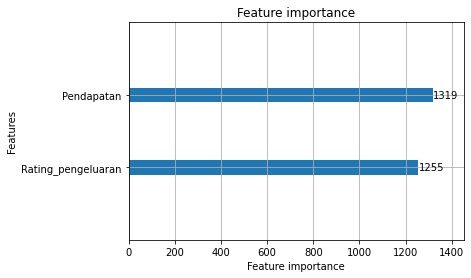

In [22]:
Xnew = mal1.iloc[:, 0:-1]
ynew = mal1.iloc[:, -1]
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnew, ynew, test_size=.2)
lgb_clf = lgb.LGBMClassifier(random_state=2020)
lgb_clf.fit(Xtrain, ytrain)
print(lgb_clf.score(Xtest, ytest))
print(lgb.plot_importance(lgb_clf))

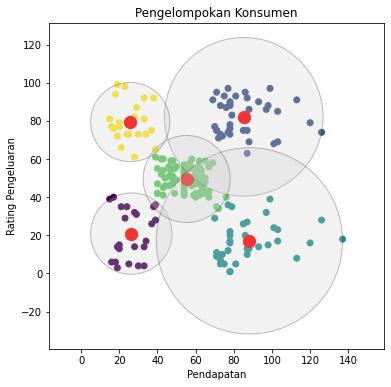

In [23]:
#Dari diagram batang diatas, variabel Pendapatan adalah prediktor yang paling menentukan
#dalam pengelompokan menjadi 5 buah cluster
#Kita juga mendapatkan akurasi 97,5 % dengan model baseline LGBM, kita tidak mengimprove akurasi ini
#karena fokus kita hanyalah Clustering

#Terakhir kita akan menginterpretasikan hasil yang telah kita dapatkan
kmeans = KMeans(5)
Xnew = Xnew.values
labels = kmeans.fit_predict(Xnew)
pusat = kmeans.cluster_centers_
jejari = [cdist(Xnew[labels==i], [p]).max() for i, p in enumerate(pusat)]   #me-return jarak pusat cluster ke datapoint terjauh
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(Xnew[:,0], Xnew[:,1], c=labels, cmap='viridis')
ax.scatter(pusat[:,0], pusat[:,1], c='red', s=150)
for j, p in zip(jejari, pusat):
  lingkaran = plt.Circle(p, j, color='k', alpha=.25, fc='#CCCCCC')
  ax.axis('equal')
  ax.add_patch(lingkaran)
  ax.set_xlabel('Pendapatan')
  ax.set_ylabel('Rating Pengeluaran')
  ax.set_title('Pengelompokan Konsumen')

In [0]:
#Interpretation time
#Cluster 1 (biru muda, kanan-bawah), adalah kelompok Konsumen yang penghasilannya besar tetapi
#kurang berminat membeli produk kita, harus segera diketahui apa alasannya atau menerapkan metode
#marketing tertentu agar produk kita lebih diminati oleh mereka

#Cluster 2 (kuning), adalah Pelanggan yang penghasilannya kecil dan Royal untuk membeli produk kita
#kita harus mempertahankan kelompok ini, perlu dicari tahu apa yang membuat mereka mau mengeluarkan
#banyak uang untuk membeli produk kita

#Cluster 3 (biru tua), adalah tipe pelanggan yang penghasilannya besar dan cukup royal denga produk kita

#Cluster 4 (hijau), cluster dengan konsumen terbanyak, penghasilan dan pengeluarannya pun sedang,
#maka bisa jadi tolak ukur dari efektivitas marketing kita

#Cluster 5 (ungu), tipe konsumen berpenghasilan rendah dan kurang berminat pada produk kita,
#mungkin perlu diberlakukan strategi diskon atau potongan harga tertentu untuk mereka


#Sekian pembahasan mengenai Clustering dari saya, Terima Kasih ^_^